# <🧰> Setting up project 

## 📥 Imports 

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import PIL # Preview Images
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Reshape, Multiply


import pathlib 

## 📦 Dataset 

### ⚙️ Config paths

In [115]:
training_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
testing_path =  '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

### ⚙️ Setting up datasets

In [116]:
batch_size = 32 
image_size = (100, 100) # height, width 

### 🎓 Training dataset 

In [117]:
train_ds = keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size = image_size,
    batch_size = batch_size,
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


### ✅ Validation dataset

In [118]:
val_ds = keras.utils.image_dataset_from_directory(
    testing_path,
    validation_split = 0.2,
    subset="validation",
    seed=123,
    image_size = image_size,
    batch_size = batch_size,
)

Found 22688 files belonging to 131 classes.
Using 4537 files for validation.


### 📝 Classes 

In [119]:
print(train_ds.class_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

### 🤝 Merge classes 

In [120]:
for i in range(len(train_ds.class_names)):
    train_ds.class_names[i] = train_ds.class_names[i].split(" ")[0]
    val_ds.class_names[i] = val_ds.class_names[i].split(" ")[0]

print(val_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### 👀 Vizualize some training dataset samples 


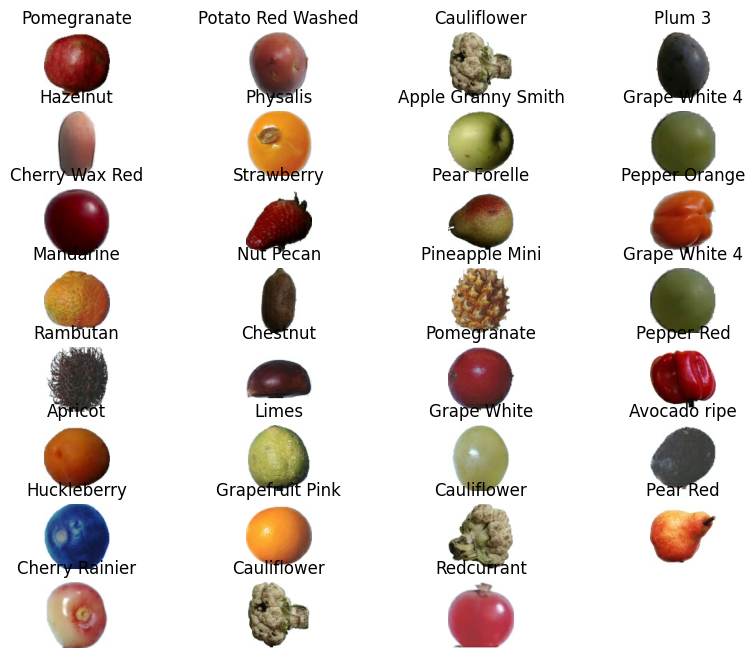

In [121]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  for i in range(len(images)-1):
        ax = plt.subplot(8, len(images)//8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### 🥝  And validation dataset too..

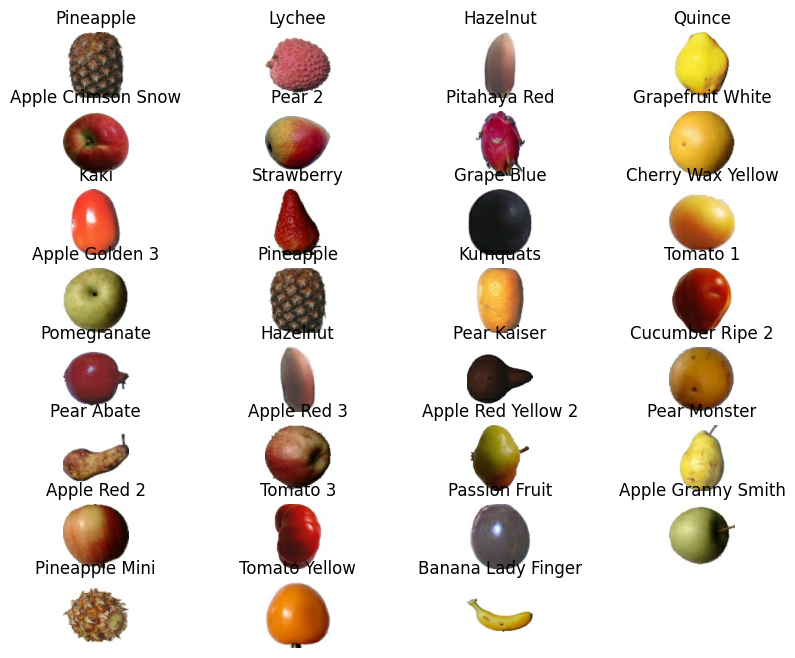

In [122]:
plt.figure(figsize=(10, 8))
for images, labels in val_ds.take(1):
  for i in range(len(images)-1):
        ax = plt.subplot(8, len(images)//8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [123]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


### 🧰 Configure Dataset

In [124]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 📦 Standardize the data 

In [125]:
normalization_layer = layers.Rescaling(1./255)

In [126]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))

first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


### 🛠️ Data augmentation

In [127]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                        input_shape=image_size),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#### 👀 Check augmented data 

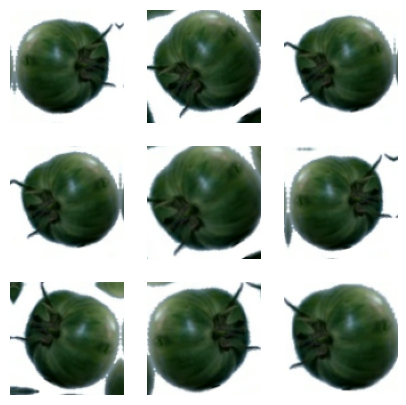

In [128]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


# ⚛️ Building the model 

In [129]:
num_classes = len(class_names)
input_shape = (100, 100, 3)
print(num_classes)

131


In [130]:
model = Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)), 
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(1024, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(2048, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes)
])


ValueError: Exception encountered when calling layer "max_pooling2d_16" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_16/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,1024].

Call arguments received by layer "max_pooling2d_16" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 1024), dtype=float32)

In [ ]:
model.compile(optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
model.summary()

## 📥 Train Model

In [ ]:
epochs = 1
print(num_classes)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)
